In [1]:
#Adrian del Pozo Hernandez
#Ines Primo Lopez

import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sg 
from tkinter import *
import tkinter as tk
#import kbhit
# gráficos en el notebook
%matplotlib inline
SRATE = 44100 # Sample rate, para todo el programa
CHUNK = 1024

In [2]:
class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)

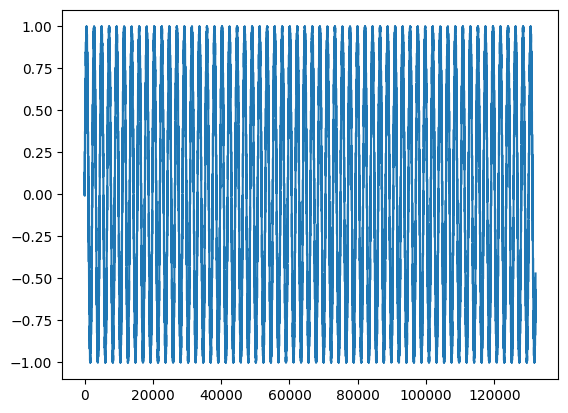

In [3]:
class OscFM:
    def __init__(self,fc=110.0,amp=1.0,fm=6.0, beta=1.0):
        self.fc = fc
        self.amp = amp
        self.fm = fm
        self.beta = beta
        self.frame = 0

        #Preguntar porque llama a esto moduladora
        # moduladora = βsin(2πfm)
        
    def next(self):  
        # sin(2πfc+mod)  
        # sacamos el siguiente chunk de la moduladora
        mod = Osc(freq=self.fm,amp=self.beta).next()

        # soporte para el chunk de salida
        sample = np.arange(self.frame,self.frame+CHUNK)        
        # aplicamos formula
        out =  self.amp*np.sin(2*np.pi*self.fc*sample/SRATE + mod)
        self.frame += CHUNK
        return out 
    
    def getFM(self):
        return self.fm
    
    def getBeta(self):
        return self.beta
    
    def setFM(self, fm):
        self.fm = fm

    def setBeta(self, beta):
        self.beta = beta
    

signal = OscFM(fc=20,fm=1000,beta=0.1)

# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

varios = np.zeros(0)
for i in range(chunks):
    varios = np.append(varios,signal.next())

sd.play(varios)

plt.plot(varios)

sd.wait()

In [4]:
def myround(x, base=110):
    return base * np.round(x/base)

class ThereminFM(OscFM):
    def __init__(self, posibleFrecuencies, fc=440.0,amp=1.0,fm=6.0, beta=1.0):
        
        super().__init__(fc, amp, fm, beta)

        self.frecuenciesTable = posibleFrecuencies
        self.minFreq = posibleFrecuencies[0]
        self.maxFreq = posibleFrecuencies[-1]

        self.minAmp = 0
        self.maxAmp = 1

    def getAmp(self):
        return self.amp

    def getFreq(self):
        return self.fc
    
    def getMaxAmp(self):
        return self.maxAmp
    
    def getMaxFreq(self):
        return self.maxFreq

    def setAmp(self, amp):
        if amp <= self.maxAmp and amp >= self.minAmp:
            self.amp = amp

    def setFreq(self, freq):
        if freq <= self.maxFreq and freq >= self.minFreq:
            self.fc = myround(freq, 110)

posiblesFrecuencias = np.array([110, 220, 330, 440, 550, 660, 770, 880, 990, 1100, ])

theremin = ThereminFM(posibleFrecuencies=posiblesFrecuencias)

def callback(outdata, frames, time, status):

    s = theremin.next()
    outdata[:] = s.reshape(-1, 1)
    

stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

WIDTH, HEIGHT = 800, 600
root = tk.Tk()
root.geometry(f"{WIDTH}x{HEIGHT}")

def motion(event):

    global theremin

    x = root.winfo_pointerx()
    y = root.winfo_pointery()
    
    theremin.setAmp((y * theremin.getMaxAmp()) / HEIGHT)
    theremin.setFreq((x * theremin.getMaxFreq()) / WIDTH)

root.bind('<Motion>', motion)

root.mainloop()

stream.stop()
stream.close()